In [38]:
import numpy as np

# some parameters
p = 500
n = 500

X = np.random.normal(size=(n,p))

# 產生 beta_true
beta_true = []
positive_elements = np.full((100), 2, dtype=int).tolist()
negative_elements = np.full((100), -2, dtype=int).tolist()

beta_true.extend(negative_elements)
beta_true.extend(negative_elements)
beta_true.extend(positive_elements)
beta_true.extend(positive_elements)
beta_true.extend(negative_elements)

beta_true = np.array(beta_true).reshape(-1,)
y = np.array(np.dot(X, beta_true) + (np.random.normal(0, 0.5))).reshape(-1,)

In [39]:
# set parameters
alpha_ls = [8, 16, 32, 64]
alpha_tilde = [float(0.5 / max(np.linalg.eigvals(np.dot(X.T, X))))*ele for ele in alpha_ls] # stepsize
num_iterations = 10000

In [40]:
print("dimension of x:", np.shape(X))
print("dimension of y:", np.shape(y))
print("dimension of true beta:", np.shape(beta_true))
print("l2 Norm of true beta:", np.linalg.norm(beta_true, ord = 2))

dimension of x: (500, 500)
dimension of y: (500,)
dimension of true beta: (500,)
l2 Norm of true beta: 44.721359549995796


In [41]:
import time
import math


def b_sequence(maxiter):
    b_list = list()
    b = 1
    for r in range(maxiter):
        b_list.append(b)
        b = (1 + math.sqrt(1 + 4* (b**2)))/2
    return b_list

# def objective_function(X ,y, theta_r, lamb):
#     return 0.5 * np.linalg.norm(y - np.dot(X, beta), ord = 2)**2 + alpha*np.֒linalg.norm(beta, ord = 0)

def gradient_function(X, y, beta):
    return np.dot(-X.T, y) + np.dot(np.dot(X.T, X), beta).reshape(-1, )

def l0_prox(X, alpha):
    # Hard thresholding
    return np.array([ele if abs(ele) >= math.sqrt(2*alpha) else 0 for ele in X])

def proximal_gradient(X, y, n, p, alpha, maxiter):
    start = time.time()
    beta_iter = np.random.normal(size=(p))
    px_beta_history = list()
    px_beta_history.append(beta_iter)
    c = 0.5 / max(np.linalg.eigvals(np.dot(X.T, X))) # stepsize
    for iterindex in range(maxiter):
        beta_tmp = l0_prox(beta_iter - c*gradient_function(X, y, beta_iter), alpha)
        beta_iter = beta_tmp
        px_beta_history.append(beta_iter)
    end = time.time()
    print("Beta norm by Proximal Gradient:", np.linalg.norm(beta_iter), ". Time ֒Cost:", end-start)
    return px_beta_history

def fast_proximal_gradient(X, y, n, p, alpha, maxiter, b):
    start = time.time()
    beta_iter = np.random.normal(size=(p))
    fpx_beta_history = list()
    fpx_beta_history.append(beta_iter)
    c = 0.5 / max(np.linalg.eigvals(np.dot(X.T, X))) # stepsize
    beta_iter_old = beta_iter
    for iterindex in range(1, maxiter):
        gamma = beta_iter + ((b[iterindex-1]-1)/(b[iterindex]))*(beta_iter - beta_iter_old)
        beta_tmp = l0_prox(gamma - c*gradient_function(X, y, gamma), alpha)
        beta_iter_old = beta_tmp
        beta_iter = beta_tmp
        fpx_beta_history.append(beta_iter)
    end = time.time()
    print("Beta norm by Fast Proximal Gradient:", np.linalg.norm(beta_iter), ".Time Cost:", end-start)
    return fpx_beta_history
    # fast_proximal_gradient(X, y, n, p, beta_new, alpha_ls[0], num_iterations, ֒b_ls)

### 2.3 Training on different alpha

In [42]:
b_ls = b_sequence(num_iterations)
proximal_history = list()
fast_proximal_history = list()
for index in alpha_tilde:
    print("alpha =", index)
    X_ = np.copy(X)
    y_ = np.copy(y)
    proximal_history.append(proximal_gradient(X_, y_, n, p, index, num_iterations))
    fast_proximal_history.append(fast_proximal_gradient(X_, y_, n, p, index, num_iterations, b_ls))
    print("----------")

alpha = 0.0019955745346535918
Beta norm by Proximal Gradient: 45.33422812467962 . Time ֒Cost: 19.001635313034058
Beta norm by Fast Proximal Gradient: 45.04624923504082 .Time Cost: 19.700525760650635
----------
alpha = 0.0039911490693071835
Beta norm by Proximal Gradient: 44.68670645679899 . Time ֒Cost: 18.613041877746582
Beta norm by Fast Proximal Gradient: 44.98509051631969 .Time Cost: 17.97781467437744
----------
alpha = 0.007982298138614367
Beta norm by Proximal Gradient: 44.79746787370443 . Time ֒Cost: 18.05140972137451
Beta norm by Fast Proximal Gradient: 44.96769568635441 .Time Cost: 18.19290256500244
----------
alpha = 0.015964596277228734
Beta norm by Proximal Gradient: 44.999039544666566 . Time ֒Cost: 18.21420383453369
Beta norm by Fast Proximal Gradient: 43.63055778759334 .Time Cost: 18.318777322769165
----------


### 2.4 Calculating the difference and plotting the graph

In [43]:
proximal_diff = []
fast_proximal_diff = []
for i in range(len(alpha_ls)):
    diff = [np.linalg.norm(proximal_history[i][j+1]-proximal_history[i][j], ord=2) for j in range(len(proximal_history[i])-1) ]
    proximal_diff.append(diff)
    diff = [np.linalg.norm(fast_proximal_history[i][j+1] - fast_proximal_history[i][j],
                           ord=2) for j in range(len(fast_proximal_history[i])-1)]
    fast_proximal_diff.append(diff)

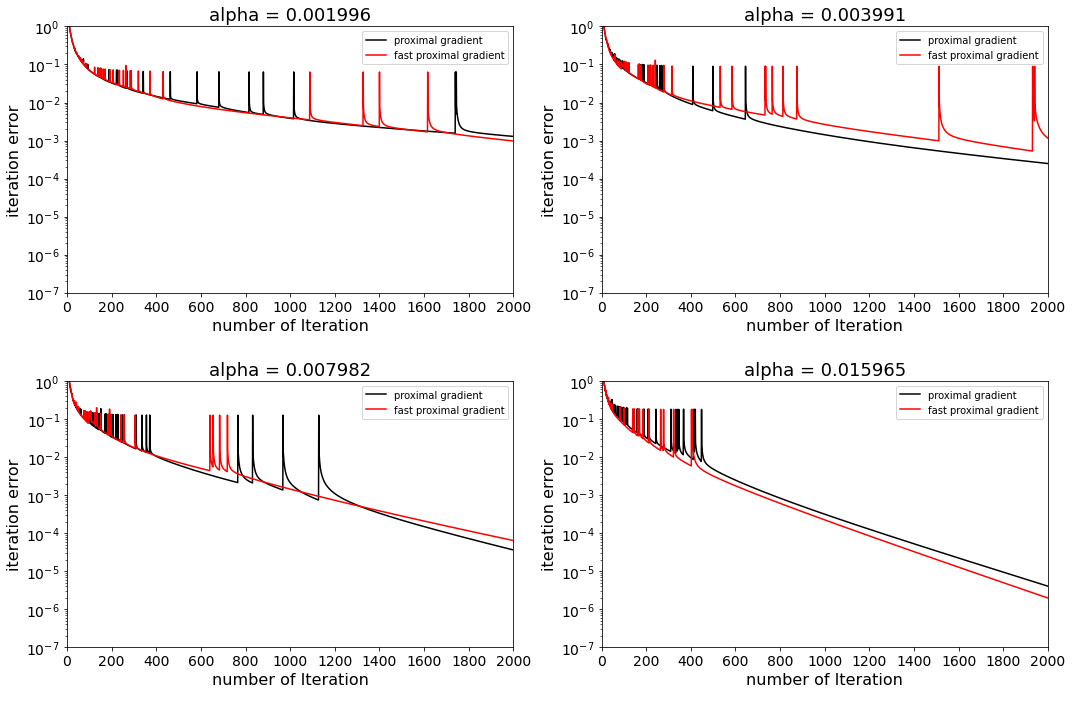

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 10))

for index in range(len(alpha_ls)):
    plt.subplot(2, 2, index+1)
    plt.plot(proximal_diff[index], label = "proximal gradient", color = "black")
    plt.plot(fast_proximal_diff[index], label = "fast proximal gradient", color = "red")

    plt.legend()
    plt.title("alpha = "+str(np.round_(alpha_tilde[index], decimals=6)), fontsize = 18)
    plt.xticks(np.arange(0, num_iterations+1,  200), fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.yscale("log")

    plt.xlim(0, 2000)
    plt.ylim(10e-8, 1)
    plt.xlabel("number of Iteration\n", fontsize = 16)
    plt.ylabel("iteration error", fontsize = 16)
plt.tight_layout()
plt.show()

In [45]:
def MSE(beta_predict, beta_true):
    return np.linalg.norm(beta_predict-beta_true, ord=2)

def training_error(X, y, beta_predict, n):
    result = np.linalg.norm(np.dot(X, beta_predict)-y, ord=2)
    result = result/n
    return result

def test_error(X_test, y_test, beta_predict, n_test):
    result = np.linalg.norm(np.dot(X_test, beta_predict)-y_test, ord=2)
    result = result/n_test
    return result

In [46]:
print(n)

n_test = 10*n

X_test = np.random.normal(size=(n_test,p))

y_test = np.array(np.dot(X_test, beta_true) + (np.random.normal(0, 0.5))).reshape(-1,)

500


In [47]:
print(X_test.shape)
print(y_test.shape)

(5000, 500)
(5000,)


In [48]:
np.asarray(proximal_history).shape

for i in range(len(alpha_ls)):

    pred = np.asarray(fast_proximal_history[i][-1])

    print(MSE(pred, beta_true))
    print(training_error(X, y, pred, n))
    print(test_error(X_test, y_test, pred, n_test))


25.674699317133236
0.14963223919095847
0.36495710119399244
30.121324247434245
0.2214875176143189
0.42803621163199185
31.33186999461327
0.2542726338438966
0.4442961012580509
35.892978168650515
0.44495746635059935
0.51753845467689
